In [4]:
# Core modules

# Non-core modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Local modules
from pac_hunter.hunter import fetch_committee_distributions, clean_candidate_df
from pac_hunter.states import us_state_to_abbrev, abbrev_to_us_state
try:
    from pac_hunter.constants import OPENFEC_API_KEY
except ImportError:
    OPENFEC_API_KEY = "DEMO_KEY"


In [18]:
# Load relevant data on election deniers, from congressional roll call on Jan 6 2021 and fivethirtyeight's data on 2022 candidates
jan6_senate = pd.read_csv("jan6-senate-deniers.csv")
url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/election-deniers/fivethirtyeight_election_deniers.csv"
ballot_deniers = pd.read_csv(url)
# The 538 data does not have a party column and includes republican candidates from the 2022 election
# It includes congressional, governor, secratary of state, and stat attorney general candidates
# Since only federal candidates register with the FEC, unfortunately this tool cannot track state gov candidates
ballot_deniers = ballot_deniers.assign(party="r")
ballot_deniers = ballot_deniers.query("Stance == 'Fully denied'") # Consider only candidates that fully denied election results
# Optionally use a lighter filter and consider candidates that avoid full denial
# ballot_deniers = ballot_deniers.query("Stance != 'Fully accepted'") # Remove candidates that fully accepted election results
# ballot_deniers = ballot_deniers.query("Stance != 'No comment'") # Remove candidates 538 has not recorded a position for


In [19]:
# Clean the dataframes for consistent columns
jan6_congress_clean = clean_candidate_df(jan6_senate)
ballot_deniers_clean = clean_candidate_df(ballot_deniers)
jan6_deniers = jan6_congress_clean.query("vote=='yea'")


In [20]:
# Combine the fivethirtyeight.com data with congressional roll call from Jan 6 2021
# Not all senators are 2022 candidates and were not tracked by fivethirtyeight
# Notably: Lummis, Hawley, Tuberville, Hyde-Smith, Marshall, Scott
jan6_deniers = jan6_deniers.assign(stance="fully denied")
deniers = pd.concat([ballot_deniers_clean, jan6_deniers], ignore_index=True)
deniers

,candidate,incumbent,state,office,district,stance,source,url,note,party,name,first_name,last_name,state_code,vote
0,katie britt,no,alabama,senator,NaN,fully denied,nbc news,https://twitter.com/vaughnhillyard/status/1528...,NaN,r,katie britt,katie,britt,al,NaN
1,jerry carl,yes,alabama,representative,1,fully denied,"congressional roll call, alabama political rep...",https://clerk.house.gov/votes/202111?date=01%2...,NaN,r,jerry carl,jerry,carl,al,NaN
2,barry moore,yes,alabama,representative,2,fully denied,congressional roll call,https://clerk.house.gov/votes/202111?date=01%2...,NaN,r,barry moore,barry,moore,al,NaN
3,mike rogers,yes,alabama,representative,3,fully denied,congressional roll call,https://clerk.house.gov/votes/202111?date=01%2...,NaN,r,mike rogers,mike,rogers,al,NaN
4,robert aderholt,yes,alabama,representative,4,fully denied,congressional roll call,https://clerk.house.gov/votes/202111?date=01%2...,NaN,r,robert aderholt,robert,aderholt,al,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,NaN,NaN,ms,NaN,NaN,fully denied,NaN,NaN,NaN,r,hyde-smith,,hyde-smith,ms,yea
202,NaN,NaN,wy,NaN,NaN,fully denied,NaN,NaN,NaN,r,lummis,,lummis,wy,yea
203,NaN,NaN,ks,NaN,NaN,fully denied,NaN,NaN,NaN,r,marshall,,marshall,ks,yea
204,NaN,NaN,fl,NaN,NaN,fully denied,NaN,NaN,NaN,r,scott,,scott,fl,yea


In [25]:
# Leverage OpenFEC API to collect distributions from a given PAC to election deniers
# This may take a few seconds, as the OpenFEC API is rate limited
denier_donations = await fetch_committee_distributions(
    api_key=OPENFEC_API_KEY,
    committee_name="raytheon technologies",
    recipient_names=deniers["name"].to_list(),
)

Multiple results for committee raytheon technologies, taking the first entry


In [26]:
# The resulting dataframe showing PAC distributions to election deniers
denier_donations.head(5)

,recipient_name,count,committee_name,cycle,committee_id,memo_total,total,memo_count,recipient_id,office_sought,id,name,candidate_id,CAND_ELECTION_YR,FEC_ELECTION_YR,CMTE_TP,CMTE_DSGN,LINKAGE_ID
0,KEN CALVERT FOR CONGRESS,2,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,1998,C00097568,0.0,1000.0,0,C00257337,H,H2CA37023,"CALVERT, KEN",H2CA37023,2022,2022,H,P,234915
1,KEN CALVERT FOR CONGRESS,2,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,2000,C00097568,0.0,1000.0,0,C00257337,H,H2CA37023,"CALVERT, KEN",H2CA37023,2022,2022,H,P,234915
2,KEN CALVERT FOR CONGRESS,3,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,2004,C00097568,0.0,3000.0,0,C00257337,H,H2CA37023,"CALVERT, KEN",H2CA37023,2022,2022,H,P,234915
3,KEN CALVERT FOR CONGRESS COMMITTEE,10,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,2012,C00097568,0.0,10000.0,0,C00257337,H,H2CA37023,"CALVERT, KEN",H2CA37023,2022,2022,H,P,234915
4,KEN CALVERT FOR CONGRESS COMMITTEE,6,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,2014,C00097568,0.0,10000.0,0,C00257337,H,H2CA37023,"CALVERT, KEN",H2CA37023,2022,2022,H,P,234915


In [27]:
# Compact the distribution data by cycle and candidate
denier_donations_by_cycle = denier_donations.groupby(["name", "office_sought", "cycle"]).sum(numeric_only=True).reset_index()
denier_donations_cumulative = denier_donations.groupby(["name", "office_sought"]).sum(numeric_only=True)["total"].reset_index()
denier_donations_cumulative.head(5)

,name,office_sought,total
0,"ADERHOLT, ROBERT B. REP.",H,92000.0
1,"ARRINGTON, JODEY COOK",H,12500.0
2,"BABIN, BRIAN",H,20500.0
3,"BRITT, KATIE BOYD",S,5000.0
4,"BURGESS, MICHAEL C. DR.",H,40000.0


<AxesSubplot: ylabel='name'>

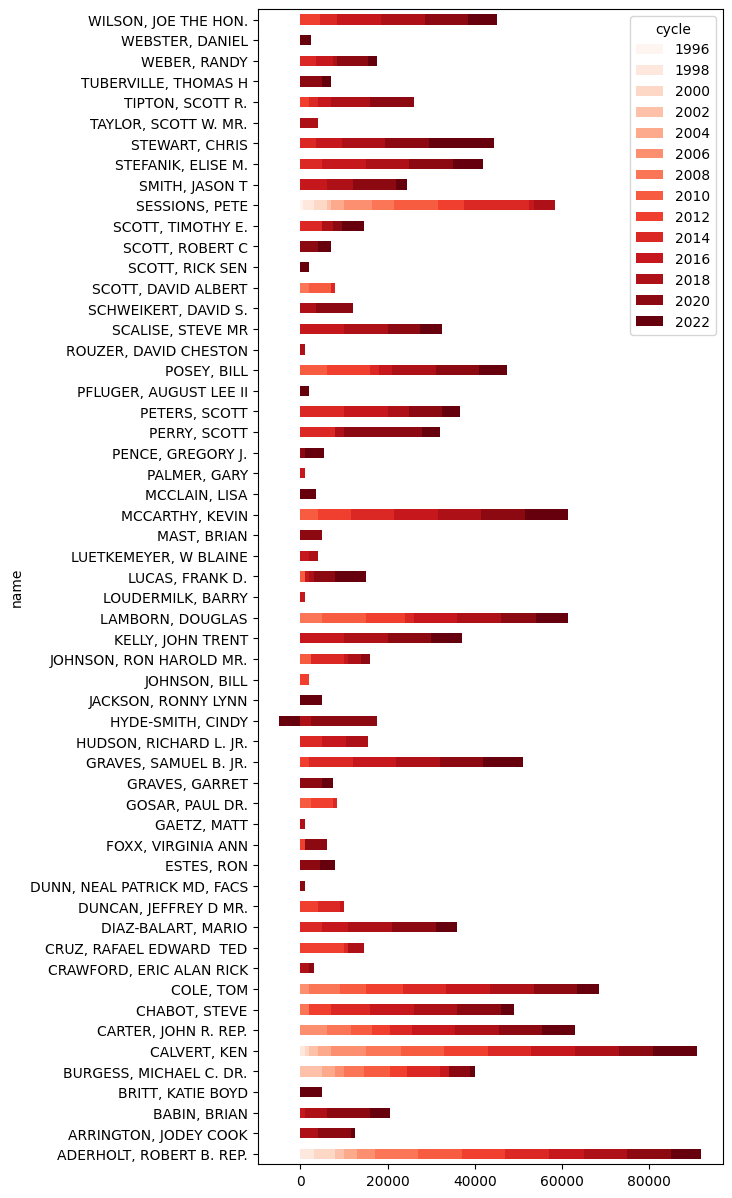

In [28]:
# Plot a stacked barchart showing total donations per candidate
df = denier_donations_by_cycle.pivot(index="name", columns="cycle", values="total")
sns.set_color_codes("muted")
df.plot(kind="barh", stacked=True, figsize=(6, 15), colormap="Reds")

<AxesSubplot: xlabel='cycle', ylabel='name'>

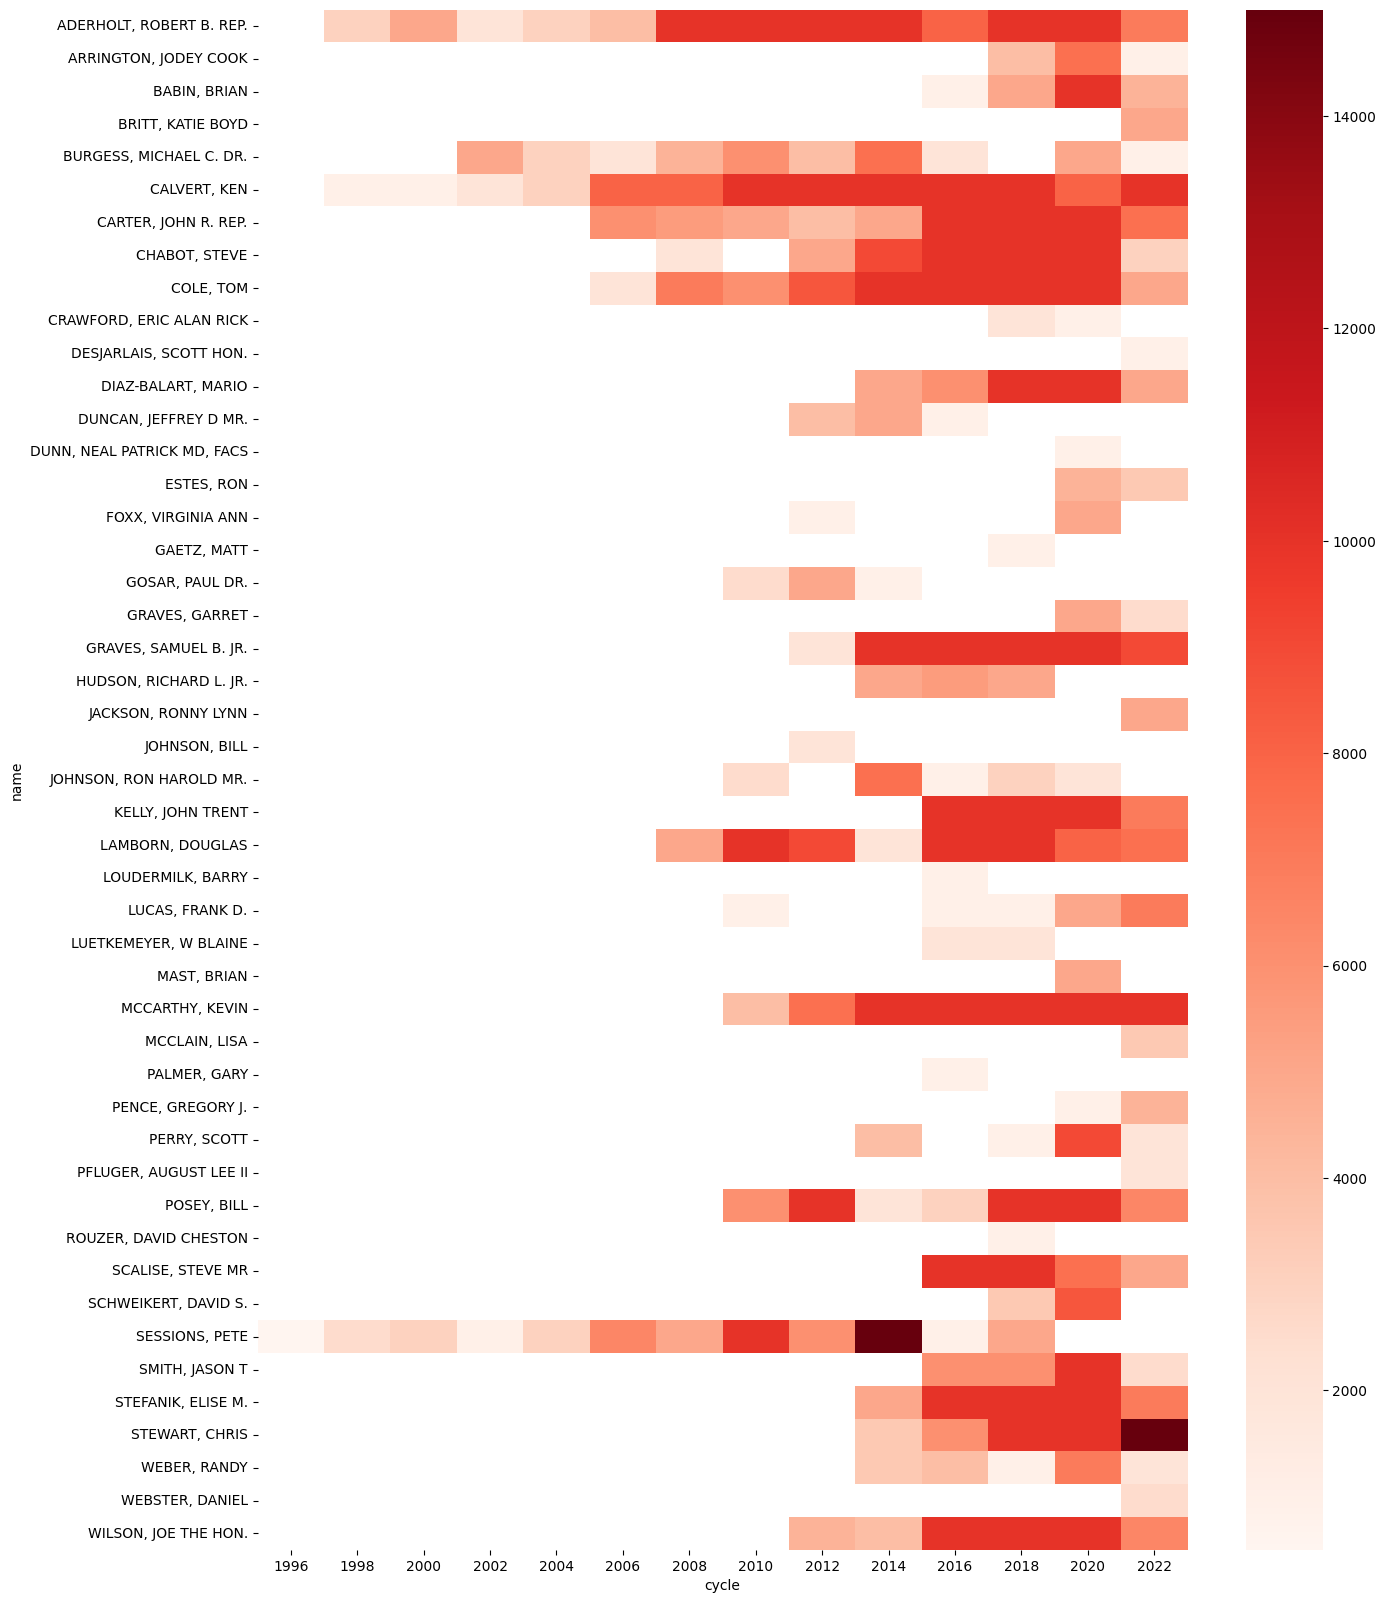

In [12]:
# Plot a heatmap showing donation history of each candidate
f, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(df, ax=ax, yticklabels="auto", cmap="Reds")